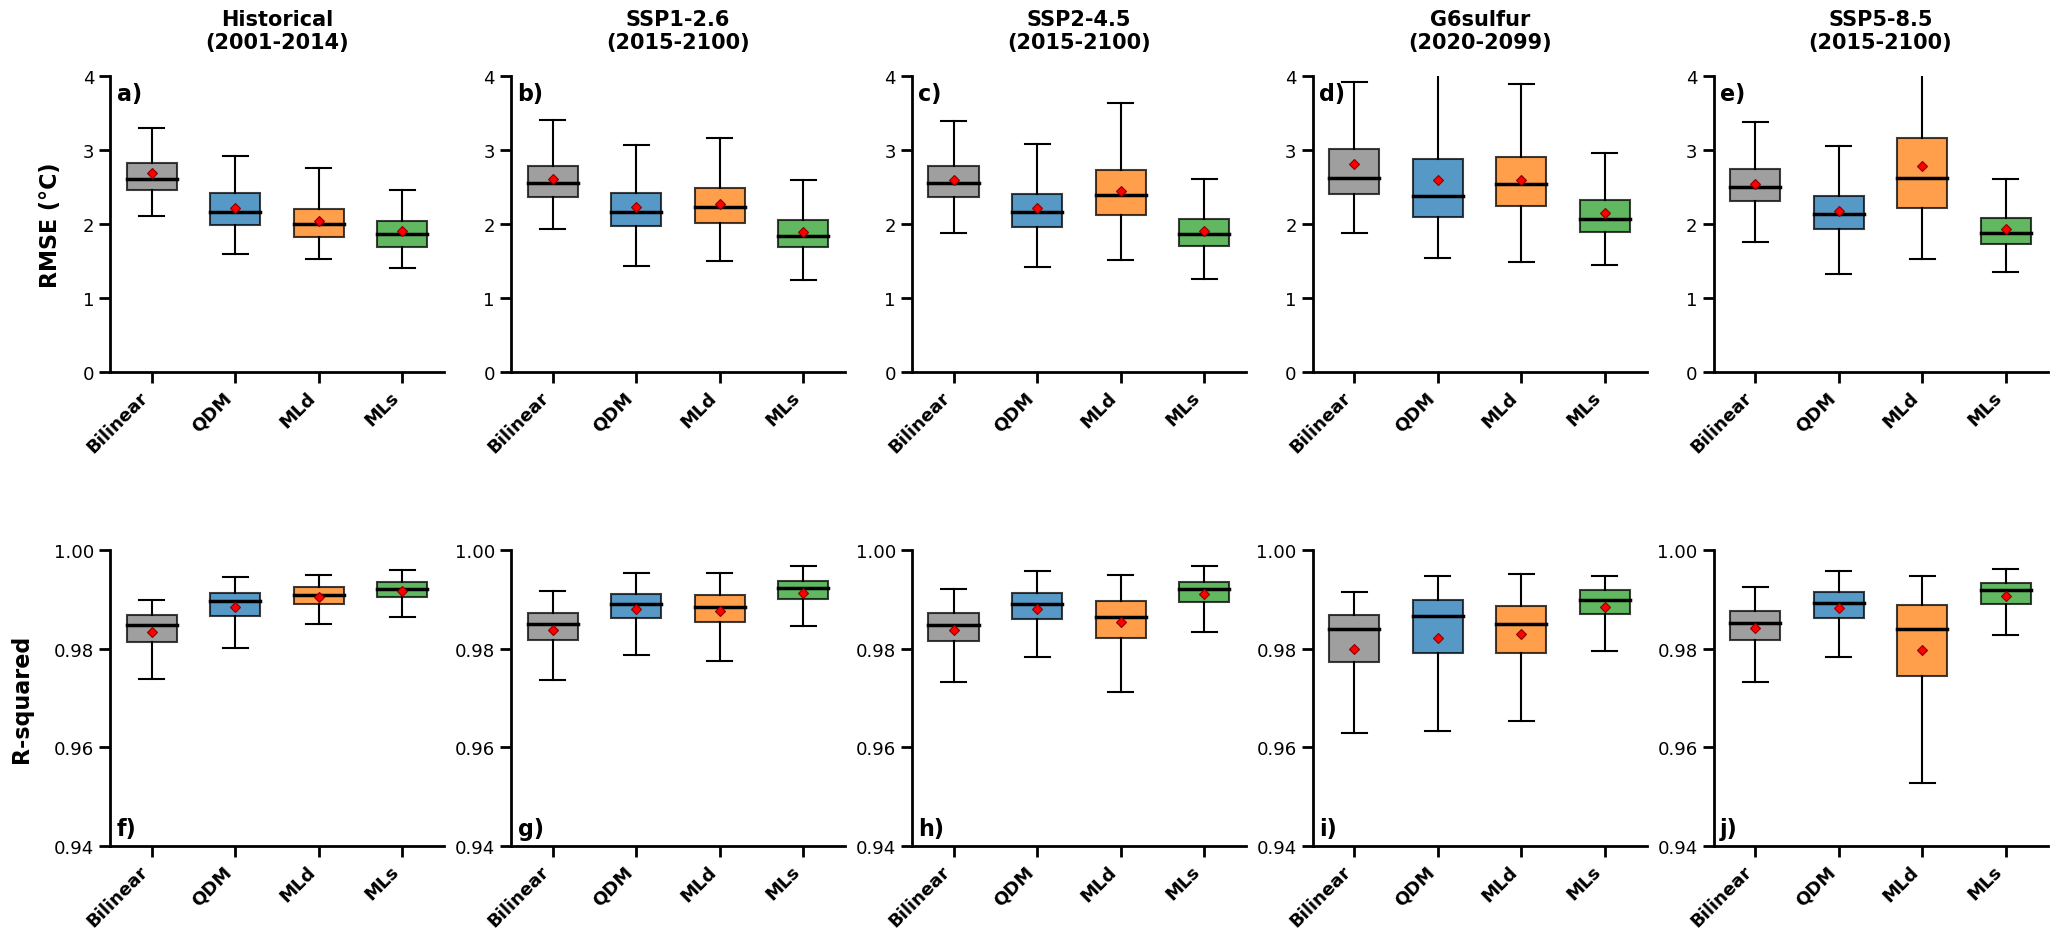

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path

# ----------------------------
# Configuration
# ----------------------------
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")

var = 'tas'
scenarios = ['historical', 'ssp126', 'ssp245', 'g6sulfur', 'ssp585']

# Model configurations
models = {
    'bilinear': 'Bilinear',
    'qdm': 'QDM',
    'zs_p': 'MLd',
    'pld_res': 'MLs'
}

# Scenario labels
scenario_labels = {
    'historical': 'Historical\n(2001-2014)',
    'ssp126': 'SSP1-2.6\n(2015-2100)',
    'ssp245': 'SSP2-4.5\n(2015-2100)',
    'g6sulfur': 'G6sulfur\n(2020-2099)',
    'ssp585': 'SSP5-8.5\n(2015-2100)'
}

# Colors for models
model_colors = {
    'bilinear': '#7f7f7f',    # Gray
    'qdm': '#1f77b4',         # Blue
    'zs_p': '#ff7f0e',        # Orange
    'pld_res': '#2ca02c'      # Green
}

# Y-axis configuration
y_axis_config = {
    'rmse': {'lim': (0, 4), 'ticks': [0, 1, 2, 3, 4]},
    'r2': {'lim': (0.94, 1), 'ticks': [0.94, 0.96, 0.98, 1.0]}
}

# ----------------------------
# Functions
# ----------------------------
def compute_spatial_rmse_timeseries(predictions, groundtruth):
    """Calculate spatial RMSE for each time point."""
    n_time = predictions.shape[0]
    rmse_values = []
    
    for t in range(n_time):
        pred_2d = predictions[t].flatten()
        gt_2d = groundtruth[t].flatten()
        rmse = np.sqrt(np.mean((pred_2d - gt_2d)**2))
        rmse_values.append(rmse)
    
    return np.array(rmse_values)

def compute_spatial_r2_timeseries(predictions, groundtruth):
    """Calculate spatial R² for each time point."""
    n_time = predictions.shape[0]
    r2_values = []
    
    for t in range(n_time):
        pred_2d = predictions[t].flatten()
        gt_2d = groundtruth[t].flatten()
        
        ss_res = np.sum((gt_2d - pred_2d)**2)
        ss_tot = np.sum((gt_2d - np.mean(gt_2d))**2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        r2_values.append(r2)
    
    return np.array(r2_values)

# ----------------------------
# Load data and compute metrics
# ----------------------------
metrics_rmse = {scen: {} for scen in scenarios}
metrics_r2 = {scen: {} for scen in scenarios}

for scenario in scenarios:
    # Load main results (for bilinear and ML-Direct)
    main_file = results_dir / f"tas_evaluation_{scenario}.nc"
    if main_file.exists():
        ds_main = xr.open_dataset(main_file)
        gt_data = ds_main['groundtruth'].values
        
        # Bilinear (input)
        if 'input' in ds_main:
            input_data = ds_main['input'].values
            metrics_rmse[scenario]['bilinear'] = compute_spatial_rmse_timeseries(input_data, gt_data)
            metrics_r2[scenario]['bilinear'] = compute_spatial_r2_timeseries(input_data, gt_data)
        
        # ML-Direct (zscore_pixel)
        if 'pred_zscore_pixel' in ds_main:
            pred_data = ds_main['pred_zscore_pixel'].values
            metrics_rmse[scenario]['zs_p'] = compute_spatial_rmse_timeseries(pred_data, gt_data)
            metrics_r2[scenario]['zs_p'] = compute_spatial_r2_timeseries(pred_data, gt_data)
    
    # Load QDM results
    qdm_file = results_dir / f"tas_evaluation_{scenario}_qdm.nc"
    if qdm_file.exists():
        ds_qdm = xr.open_dataset(qdm_file)
        gt_data = ds_qdm['groundtruth'].values
        
        if 'pred_qdm' in ds_qdm:
            pred_data = ds_qdm['pred_qdm'].values
            metrics_rmse[scenario]['qdm'] = compute_spatial_rmse_timeseries(pred_data, gt_data)
            metrics_r2[scenario]['qdm'] = compute_spatial_r2_timeseries(pred_data, gt_data)
    
    # Load residual results (for ML-Stationary)
    residual_file = results_residual_dir / f"tas_evaluation_{scenario}.nc"
    if residual_file.exists():
        ds_residual = xr.open_dataset(residual_file)
        gt_data = ds_residual['groundtruth'].values
        
        if 'pred_grid' in ds_residual:
            pred_data = ds_residual['pred_grid'].values
            metrics_rmse[scenario]['pld_res'] = compute_spatial_rmse_timeseries(pred_data, gt_data)
            metrics_r2[scenario]['pld_res'] = compute_spatial_r2_timeseries(pred_data, gt_data)

# ----------------------------
# Create 2x5 visualization
# ----------------------------
fig, axes = plt.subplots(2, 5, figsize=(25, 10))

panel_labels = [chr(97 + i) for i in range(10)]  # a, b, c, ..., j

for row, metric_type in enumerate(['rmse', 'r2']):
    for col, scenario in enumerate(scenarios):
        ax = axes[row, col]
        panel_idx = row * 5 + col
        
        if metric_type == 'rmse':
            metrics = metrics_rmse
            ylabel = 'RMSE (°C)'
            y_config = y_axis_config['rmse']
        else:
            metrics = metrics_r2
            ylabel = 'R-squared'
            y_config = y_axis_config['r2']
        
        # Prepare data for box plot
        box_data = []
        positions = []
        colors = []
        labels = []
        
        for i, (model_key, model_name) in enumerate(models.items()):
            if model_key in metrics[scenario]:
                box_data.append(metrics[scenario][model_key])
                positions.append(i + 1)
                colors.append(model_colors[model_key])
                labels.append(model_name)
        
        # Create box plot
        bp = ax.boxplot(box_data, positions=positions, widths=0.6,
                        patch_artist=True, showfliers=False,
                        medianprops=dict(color='black', linewidth=2.5),
                        boxprops=dict(linewidth=1.5),
                        whiskerprops=dict(linewidth=1.5),
                        capprops=dict(linewidth=1.5))
        
        # Color the boxes
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.75)
        
        # Add mean marker (red diamond)
        for i, data_values in enumerate(box_data):
            mean_val = np.mean(data_values)
            ax.plot(positions[i], mean_val, 'D', color='red', 
                   markersize=5, zorder=10, markeredgecolor='darkred', 
                   markeredgewidth=0.8)
        
        # Add panel label
        if row == 0:
            ax.text(0.02, 0.98, f'{panel_labels[panel_idx]})', 
                   transform=ax.transAxes, fontsize=16, fontweight='bold',
                   va='top', ha='left')
        else:
            ax.text(0.02, 0.02, f'{panel_labels[panel_idx]})', 
                   transform=ax.transAxes, fontsize=16, fontweight='bold',
                   va='bottom', ha='left')
        
        # Formatting
        ax.set_xticks(positions)
        ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=11, fontweight='bold')
        ax.set_ylim(y_config['lim'])
        ax.set_yticks(y_config['ticks'])
        
        if col == 0:
            ax.set_ylabel(ylabel, fontsize=16, fontweight='bold', labelpad=15)
        
        if row == 0:
            ax.set_title(scenario_labels[scenario], fontsize=15, fontweight='bold', pad=20)
        
        # Spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        
        ax.tick_params(axis='both', which='major', labelsize=13, length=8, width=2, colors='black')

plt.subplots_adjust(hspace=0.6)

# Save figure
output_file = figures_dir / "fig2.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()